In [37]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout


In [8]:
data_folder = 'data/'
data_folder_mass = 'data/MassModels/'
data = np.loadtxt(data_folder_mass+'NGC2403.NFW.fix.REV.dat', skiprows=12) 
df = pd.DataFrame(data, columns=['Radius', 'vgas', 'vdisk', 'vbulge', 'vobs', 'err_vobs', 'Vu', 'Vt','Rxv', 'Vxy'])

In [9]:
N = len(df.values)
df.head()

,Radius,vgas,vdisk,vbulge,vobs,err_vobs,Vu,Vt,Rxv,Vxy
0,0.06252,-0.878,-1.02499,8.48001,1.98,6.926,12.9353,15.4081,0.0,0.0
1,0.12500,-1.771,4.32810,15.26710,15.78,7.691,18.2399,24.1117,0.0,0.0
2,0.18760,-2.740,8.67483,20.65930,22.30,4.584,22.2837,31.4820,0.0,0.0
3,0.25010,-3.448,12.47880,25.01450,32.16,4.542,25.6589,37.7881,0.0,0.0
4,0.31260,-3.847,16.36670,28.54780,39.67,4.433,28.6082,43.4336,0.0,0.0


In [12]:
df = df[['Radius', 'vobs','err_vobs', 'Vt']]
df.head()

,Radius,vobs,err_vobs,Vt
0,0.06252,1.98,6.926,15.4081
1,0.12500,15.78,7.691,24.1117
2,0.18760,22.30,4.584,31.4820
3,0.25010,32.16,4.542,37.7881
4,0.31260,39.67,4.433,43.4336


In [19]:
 df['Radius'].values

array([ 0.06252,  0.125  ,  0.1876 ,  0.2501 ,  0.3126 ,  0.3751 ,
        0.4377 ,  0.5002 ,  0.5627 ,  0.6252 ,  0.6878 ,  0.7503 ,
        0.8128 ,  0.8753 ,  0.9379 ,  1.     ,  1.063  ,  1.125  ,
        1.188  ,  1.25   ,  1.313  ,  1.376  ,  1.438  ,  1.501  ,
        1.563  ,  1.626  ,  1.688  ,  1.751  ,  1.813  ,  1.876  ,
        1.938  ,  2.001  ,  2.063  ,  2.126  ,  2.188  ,  2.251  ,
        2.313  ,  2.376  ,  2.438  ,  2.501  ,  2.563  ,  2.626  ,
        2.689  ,  2.751  ,  2.814  ,  2.876  ,  2.939  ,  3.001  ,
        3.064  ,  3.126  ,  3.189  ,  3.251  ,  3.314  ,  3.376  ,
        3.439  ,  3.501  ,  3.564  ,  3.626  ,  3.689  ,  3.751  ,
        3.814  ,  3.877  ,  3.939  ,  4.002  ,  4.064  ,  4.127  ,
        4.189  ,  4.252  ,  4.314  ,  4.377  ,  4.439  ,  4.502  ,
        4.564  ,  4.627  ,  4.689  ,  4.752  ,  4.814  ,  4.877  ,
        4.939  ,  5.002  ,  5.064  ,  5.127  ,  5.19   ,  5.252  ,
        5.315  ,  5.377  ,  5.44   ,  5.502  ,  5.565  ,  5.62

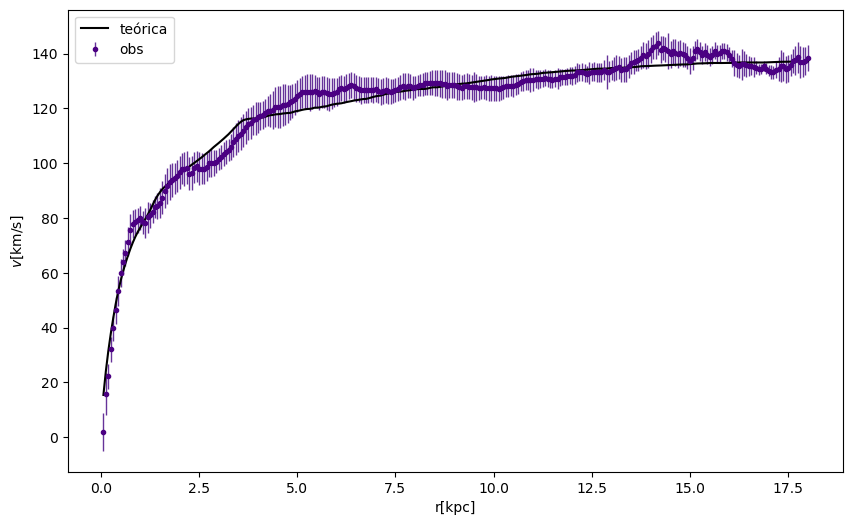

In [27]:
fig = plt.figure(figsize=(10, 6))
#plt.errorbar(mass_models[0].values, total['vrot'].values, yerr=total['err'].values, fmt='.', color='k', elinewidth=1, ecolor='green', label='total')
plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='indigo', elinewidth=1, ecolor='rebeccapurple', label='obs')
plt.plot(df['Radius'].values, df['Vt'].values, color='k', label='teórica')

plt.ylabel("$v$[km/s]")
plt.xlabel("r[kpc]")
plt.legend()

In [49]:
randomize = np.random.permutation(N)
data = df.values[randomize]

z = data[:,0]
y = data[:,1:]

In [50]:
y[:,0].shape

(288,)

In [31]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [45]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(y_train), np.shape(z_test), np.shape(y_test)

((230, 1), (230, 3), (58, 1), (58, 3))

In [33]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((230, 1), (230, 1), (58, 1), (58, 1))

In [38]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [44]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))



Epoch 1/1000


ValueError: in user code:

    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/gaby/anaconda3/lib/python3.9/site-packages/keras/src/losses.py", line 1608, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 2 and 3 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense_3/BiasAdd, IteratorGetNext:1)' with input shapes: [?,2], [?,3].


In [33]:
model_train.history['val_loss'][-1]

57.58123016357422

In [51]:


# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(3, 1150, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



32/32 [==============================] - 0s 758us/step


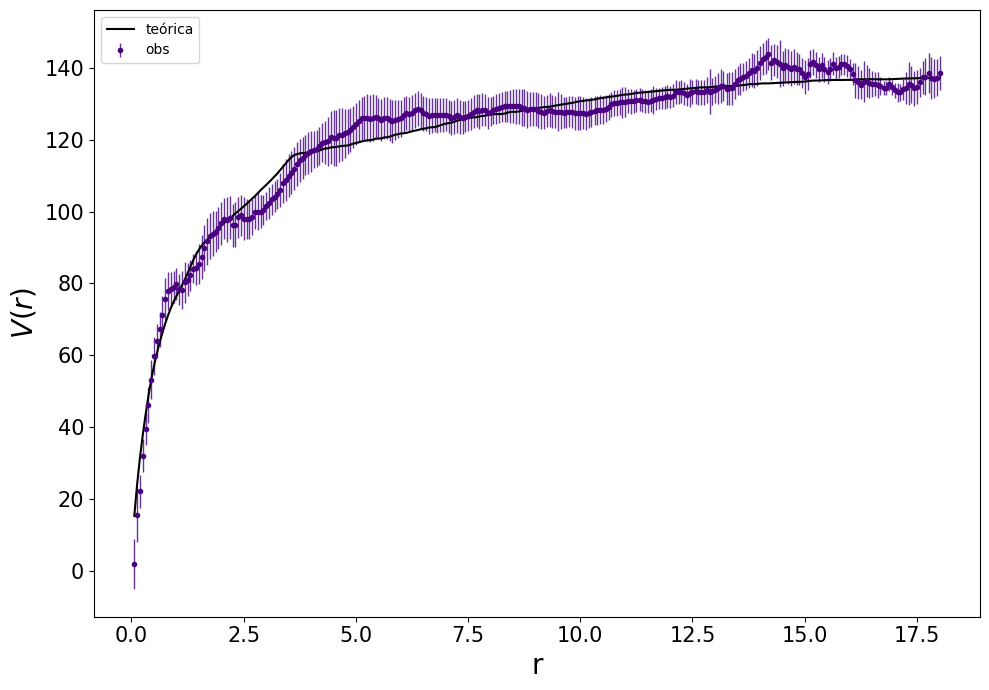

In [54]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='indigo', elinewidth=1, ecolor='rebeccapurple', label='obs')
plt.plot(df['Radius'].values, df['Vt'].values, color='k', label='teórica')

plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Neural synthetic data with $\sigma$')


# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$V(r)$", fontsize=20)
plt.xlabel("r", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("neural_reconstruction_RC.png", dpi=100)

(0.0, 100.0)

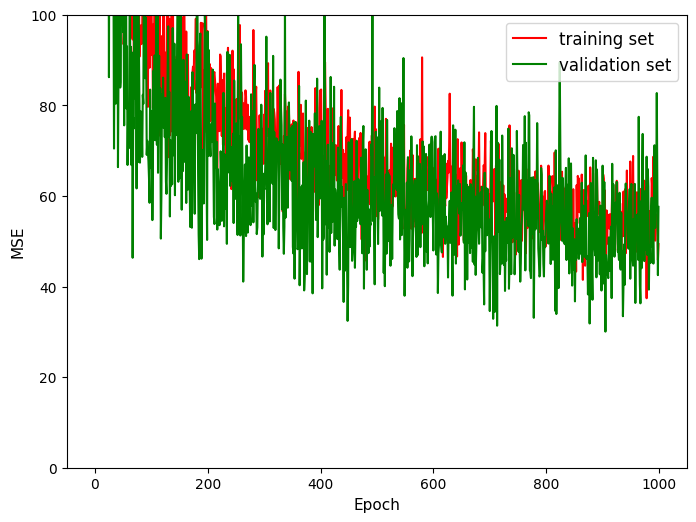

In [53]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 100)